# Support Vector Machines / Regressions

These are like linear regressions on steroids. They work in a similar way, but they don't penalize everything i.e. allow for some noise. <br>

Instead of minimizing the error like ordinary linear regression, SVR tries to:
 - Fit a flat function (as flat as possible),
 - That stays within an epsilon-wide tube around the actual data points,
 - And ignores small errors as long as the prediction stays inside this tube.

In [6]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.plotting import plot_triangle

So, let's first look at a fixed triangle. We keep `one_side=4` and the `degree=90` and add a noise to the real hypotenus values. Then look at how the "allowed margin" behaves.

In [14]:
# 1D case: let’s fix b=4, angle=90, so y = sqrt(a² + 16)
a_vals = np.linspace(1, 100, 100).reshape(-1, 1)
b_fixed = 4
angle_fixed = 90
y_vals = np.sqrt(a_vals.flatten()**2 + b_fixed**2)

# Add some slight noise
y_noisy = y_vals + np.random.normal(0, 2.5, size=len(y_vals))

# Fit SVR to this 1D case
EPS = 1.5 ## this is the tolerance for the SVR
svr_simple = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10, epsilon=EPS))
svr_simple.fit(a_vals, y_noisy)
y_pred = svr_simple.predict(a_vals)

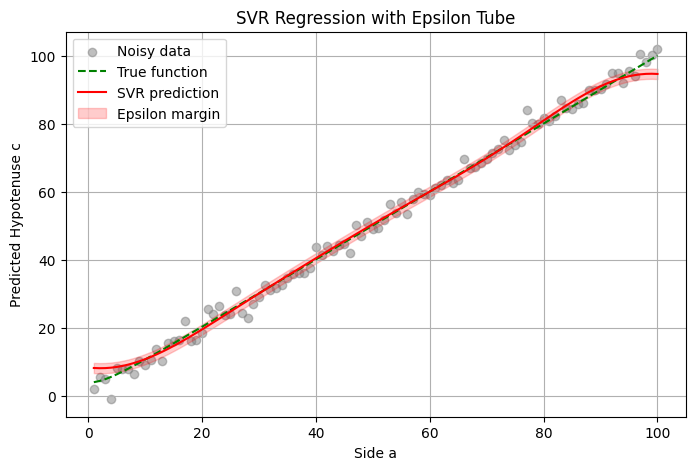

In [15]:
# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(a_vals, y_noisy, color='gray', alpha=0.5, label='Noisy data')
plt.plot(a_vals, y_vals, 'g--', label='True function')
plt.plot(a_vals, y_pred, 'r', label='SVR prediction')
plt.fill_between(a_vals.flatten(), y_pred - EPS, y_pred + EPS, color='red', alpha=0.2, label='Epsilon margin')
plt.title("SVR Regression with Epsilon Tube")
plt.xlabel("Side a")
plt.ylabel("Predicted Hypotenuse c")
plt.legend()
plt.grid(True)
plt.show()


There are also several kernels possible. We can look at them in this simple example

In [18]:
svr_models_dict = {}
y_pred_dict = {}
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    _svr = make_pipeline(StandardScaler(), SVR(kernel=kernel, C=10, epsilon=EPS))
    _svr.fit(a_vals, y_noisy)
    svr_models_dict[kernel] = _svr
    y_pred_dict[kernel] = _svr.predict(a_vals)

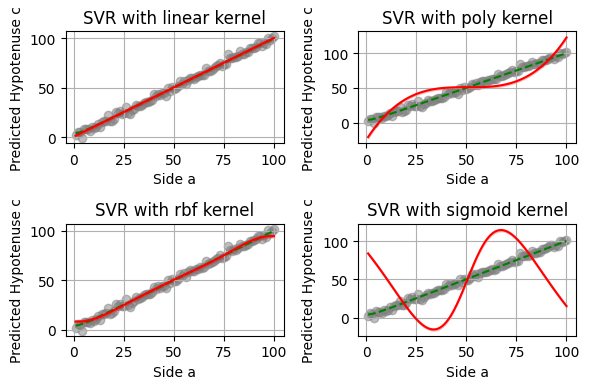

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.flatten()
for ax, (kernel, y_pred) in zip(axes, y_pred_dict.items()):
    ax.scatter(a_vals, y_noisy, color='gray', alpha=0.5, label='Noisy data')
    ax.plot(a_vals, y_vals, 'g--', label='True function')
    ax.plot(a_vals, y_pred, 'r', label='SVR prediction')
    ax.fill_between(a_vals.flatten(), y_pred - EPS, y_pred + EPS, color='red', alpha=0.2, label='Epsilon margin')
    ax.set_title(f"SVR with {kernel} kernel")
    ax.set_xlabel("Side a")
    ax.set_ylabel("Predicted Hypotenuse c")
    # ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

The kernels are basically transforming the data into a different coordinate space where a linear separation might be possible. Let's now look at the actual data with any angle

In [22]:
df_angle = generate_triangle_data(n_samples=10_000, angle_mode="random")
X_train, X_test, y_train, y_test = train_test_split(df_angle[["a", "b", "angle_deg"]], 
                                                    df_angle["c"],test_size=0.2, random_state=42)

In [27]:
# Create SVR pipeline with normalization
svr_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=20, epsilon=0.5))

# Train
svr_model.fit(X_train, y_train)

# Predict
y_pred = svr_model.predict(X_test)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))

MSE: 0.43321205191903517
R² score: 0.9996948081122942


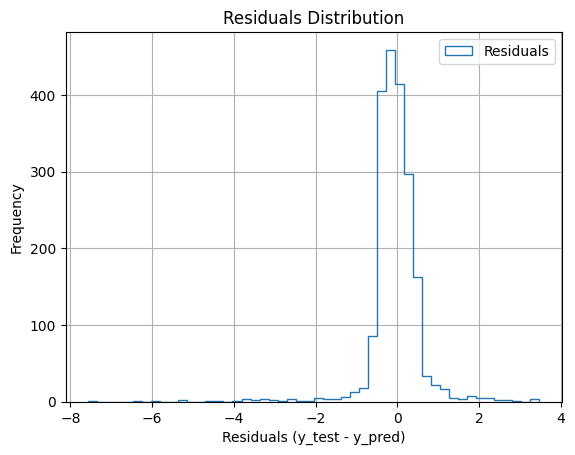

In [29]:
plt.hist(y_test - y_pred, bins=50, histtype='step', label='Residuals');
plt.xlabel('Residuals (y_test - y_pred)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show();

So this is already quite good.